In [63]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


In [64]:
import os

path = "/kaggle/input/asl-alphabet"
activities = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

print("Files:", os.listdir(path))
print(f"Categories: {activities}")

for a in activities:
    print(f"{a}: {len(os.listdir(os.path.join(path, a)))} samples")

Files: ['asl_alphabet_test', 'asl_alphabet_train']
Categories: ['asl_alphabet_test', 'asl_alphabet_train']
asl_alphabet_test: 1 samples
asl_alphabet_train: 1 samples


**Show images of the daatset**

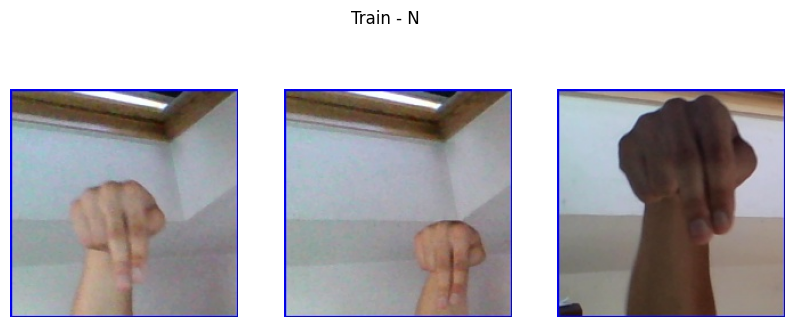

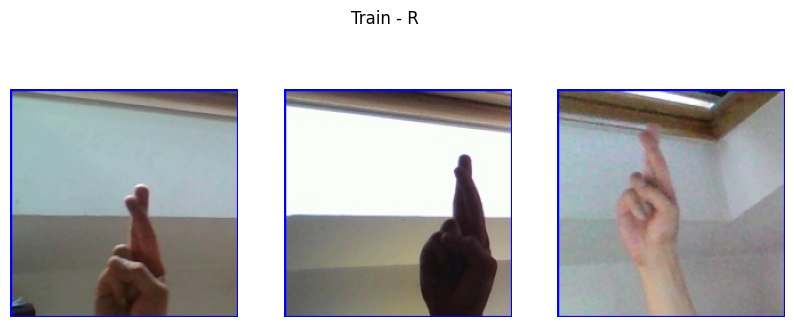

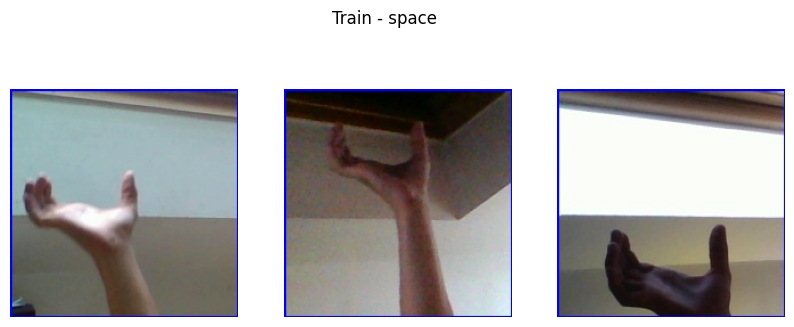

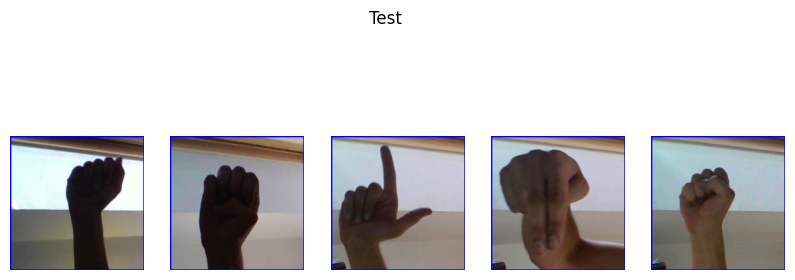

In [65]:
import os
import matplotlib.pyplot as plt
import cv2

def show_images(path, title, num=5, per_cat=False):
    cats = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))] if per_cat else [""]
    for cat in cats[:3]:
        imgs = [f for f in os.listdir(os.path.join(path, cat)) if f.endswith(('.png', '.jpg', '.jpeg'))][:num]
        fig, axes = plt.subplots(1, num, figsize=(10, 4))
        fig.suptitle(f"{title} - {cat}" if cat else title)
        for ax, img in zip(axes, imgs):
            ax.imshow(cv2.cvtColor(cv2.imread(os.path.join(path, cat, img)), cv2.COLOR_BGR2RGB))
            ax.axis("off")
        plt.show()

base = "/kaggle/input/asl-alphabet"
show_images(f"{base}/asl_alphabet_train/asl_alphabet_train", "Train", num=3, per_cat=True)
show_images(f"{base}/asl_alphabet_test/asl_alphabet_test", "Test", num=5)

In [66]:
def prepare_dataset(path, img_size=(64, 64), max_images=200):  
    X, y, categories = [], [], sorted(os.listdir(path))
    for label, cat in enumerate(categories):
        cat_path = os.path.join(path, cat)
        images = os.listdir(cat_path)[:max_images]  
        for img_name in images:
            img = cv2.imread(os.path.join(cat_path, img_name))
            if img is not None:
                X.append(cv2.resize(img, img_size) / 255.0)
                y.append(label)
    return np.array(X), np.array(y)

**Convert Images to NumPy Arrays and Normalize**

In [67]:
import numpy as np
import os
import cv2

def load_data(path, img_size=(64, 64), max_images=200):  
    X, y, categories = [], [], sorted(os.listdir(path))
    for label, cat in enumerate(categories):
        cat_path = os.path.join(path, cat)
        images = os.listdir(cat_path)[:max_images]  
        for img_name in images:
            img = cv2.imread(os.path.join(cat_path, img_name))
            if img is not None:
                X.append(cv2.resize(img, img_size) / 255.0)
                y.append(label)
    return np.array(X), np.array(y)

train_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
X, y = load_data(train_path, max_images=100) 

print(f"Loaded {X.shape[0]} images, Image shape: {X.shape[1:]}")

Loaded 2900 images, Image shape: (64, 64, 3)


Sample Array Data (First Image):
 [[[0.90196078 0.00784314 0.00392157]
  [0.7372549  0.05098039 0.05490196]]

 [[0.76078431 0.06666667 0.0745098 ]
  [0.52941176 0.54117647 0.50588235]]]


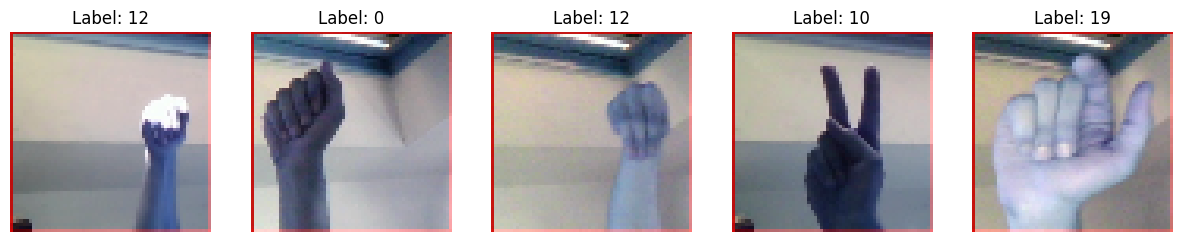

In [68]:
import matplotlib.pyplot as plt

indices = np.random.choice(len(X), 5, replace=False)

print("Sample Array Data (First Image):\n", X[indices[0]][:2, :2, :])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(indices):
    axes[i].imshow(X[idx])
    axes[i].axis("off")
    axes[i].set_title(f"Label: {y[idx]}")
plt.show()

# **CNN_LSTM model**  # 

In [69]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

IMG_SIZE = (64, 64)
SEQUENCE_LENGTH = 5
NUM_CLASSES = 30
BATCH_SIZE = 32
EPOCHS = 50

def prepare_dataset(path, img_size=IMG_SIZE, max_images=200):
    X, y, categories = [], [], sorted(os.listdir(path))
    for label, cat in enumerate(categories):
        cat_path = os.path.join(path, cat)
        images = os.listdir(cat_path)[:max_images]
        sequence = []
        for img_name in images:
            img = cv2.imread(os.path.join(cat_path, img_name))
            if img is not None:
                img = cv2.resize(img, img_size) / 255.0
                sequence.append(img)
                if len(sequence) == SEQUENCE_LENGTH:
                    X.append(sequence)
                    y.append(label)
                    sequence = []
    return np.array(X), np.array(y)

def build_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

        TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),

        TimeDistributed(GlobalAveragePooling2D()),

        LSTM(128, return_sequences=False),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_data_generator(X, y, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def main():
    train_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
    X, y = prepare_dataset(train_path, max_images=100)
    y = y[:len(X)]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    train_dataset = create_data_generator(X_train, y_train)
    val_dataset = create_data_generator(X_val, y_val, shuffle=False)

    input_shape = (SEQUENCE_LENGTH, *IMG_SIZE, 3)
    model = build_model(input_shape, NUM_CLASSES)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_91                  │ (None, 5, 64, 64, 32)       │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_92                  │ (None, 5, 64, 64, 32)       │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_93                  │ (None, 5, 32, 32, 32)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_94                  │ (None, 5, 32, 32, 64)       │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_95                  │ (None, 5, 32, 32, 64)       │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_96                  │ (None, 5, 16, 16, 64)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_97                  │ (None, 5, 16, 16, 128)      │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_98                  │ (None, 5, 16, 16, 128)      │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_99                  │ (None, 5, 8, 8, 128)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_100                 │ (None, 5, 128)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,934 (921.62 KB)

 Trainable params: 235,486 (919.87 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.0532 - loss: 3.3709 - val_accuracy: 0.0345 - val_loss: 3.4481 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1192 - loss: 3.1640 - val_accuracy: 0.0345 - val_loss: 3.5931 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1296 - loss: 2.9783 - val_accuracy: 0.0345 - val_loss: 3.8646 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2137 - loss: 2.6741 - val_accuracy: 0.0345 - val_loss: 4.7357 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2952 - loss: 2.3557 - val_accuracy: 0.0345 - val_loss: 5.7059 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3642 - loss: 2.0796 - val_accuracy: 0.0345 - val_loss: 5.7013 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4717 - loss: 1.7118 - val_ac

# **Testing and Prediction of the model**

In [54]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print(f"Model accuracy on test data: {accuracy:.4f}")

Model accuracy on test data: 0.8793


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


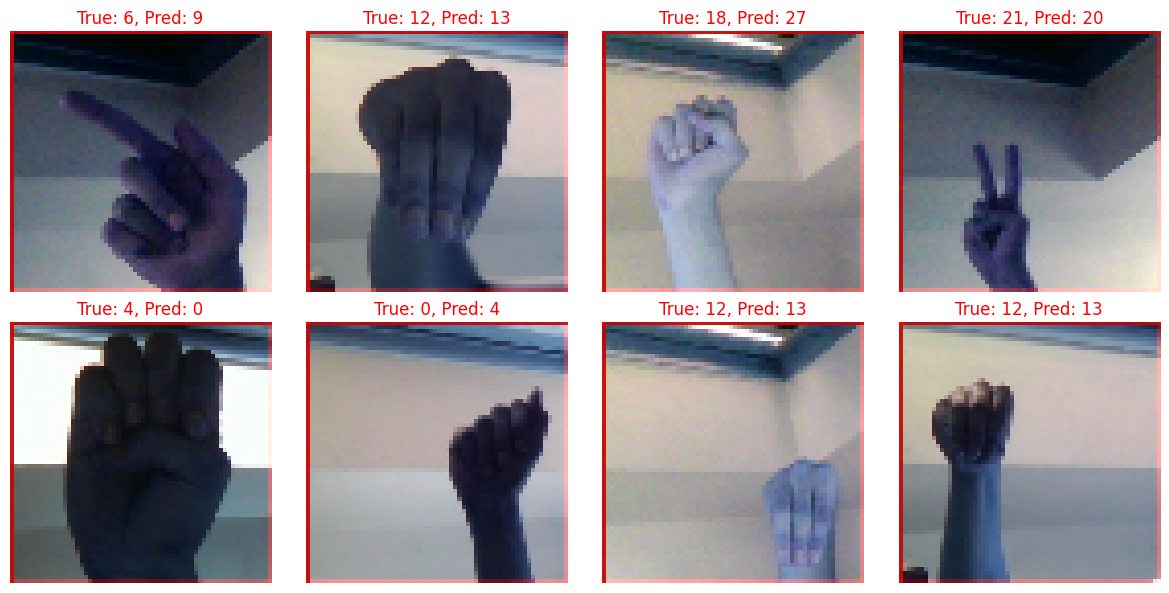

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_misclassified(X, y_true, y_pred, num_images=6):
    misclassified_idxs = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idxs) == 0:
        print("No misclassified images found!")
        return
    
    selected_idxs = random.sample(list(misclassified_idxs), min(num_images, len(misclassified_idxs)))

    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(selected_idxs):
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        
        img = X[idx]

        if img.ndim == 4:
            img = img[0]  

        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        
        if img.ndim == 3 and img.shape[-1] == 3:
            plt.imshow(img)
        elif img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            print(f"Error in image {idx} with shape {img.shape}")
            continue
        
        plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}", color="red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

show_random_misclassified(X_val, y_val, y_pred, num_images=8)